# Replicating R Code -> Python

Let's replicate the R code posted [here](https://github.com/acmiceli/IACModel) to Python. The original C++/cpp code is [here](https://web.archive.org/web/20161217150101/http://164.15.18.1/pdp/IAC/sketch_041210a.pde), but does not include necessary data files.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
import matplotlib.pyplot as plt
import networkx as nx
from dash import Dash, dcc, html
import plotly.graph_objects as go

# Loading CSV files using the current working directory & coerce non-numeric!
base_dir = os.getcwd()
f2F = pd.read_csv('JS_features2features.csv', index_col=0).apply(pd.to_numeric, errors='coerce').fillna(0).values 
f2H = pd.read_csv('JS_features2Hidden.csv', index_col=0).apply(pd.to_numeric, errors='coerce').fillna(0).values

In [2]:
# Constants - Initial implementation based on Axel's code

MAX_ACT = 1.0   # Maximum activation value
MIN_ACT = -1.0  # Minimum activation value
REST = -0.1     # Resting activation value
DECAY = 0.1     # Decay rate for activation
ESTR = 0.4      # External input strength
ALPHA = 0.2     # Learning rate or interaction scaling factor
GAMMA = 0.1     # Inhibition scaling factor
NCYCLES = 100   # Number of simulation cycles


class Pool:
    def __init__(self, poolNumber, name, poolType, unitNames, projections, weights, extInput=None):
        self.poolNumber = poolNumber
        self.name = name
        self.poolType = poolType  # Instantiate as 'input' or 'hidden'!
        self.unitNames = unitNames
        self.nUnits = len(unitNames)
        self.projections = projections
        self.weights = weights
        self.extInput = np.zeros(self.nUnits) if extInput is None else extInput
        self.activation = np.zeros(self.nUnits)
        self.inhibition = np.zeros(self.nUnits)
        self.excitation = np.zeros(self.nUnits)
        self.netInput = np.zeros(self.nUnits)
        self.activationHistory = []

    def setExtInput(self, inputVector):
        self.extInput = np.array(inputVector)


def RunSimulation(pools, nCycles):
    for _ in range(nCycles):
        for pool in pools:
            pool.excitation.fill(0)
            pool.inhibition.fill(0)
            for senderIdx in pool.projections:
                senderPool = pools[senderIdx]
                positiveActsIndices = np.where(senderPool.activation > 0)[0]
                for idx in positiveActsIndices:
                    weights = pool.weights[senderIdx][idx, :]
                    pool.excitation[weights > 0] += senderPool.activation[idx] * weights[weights > 0]
                    pool.inhibition[weights < 0] += senderPool.activation[idx] * weights[weights < 0]
            pool.excitation *= ALPHA
            pool.inhibition *= GAMMA
            pool.netInput = pool.excitation + pool.inhibition + ESTR * pool.extInput

        # Update activations
        for pool in pools:
            posNetInput = pool.netInput > 0
            negNetInput = pool.netInput <= 0
            pool.activation[posNetInput] += (
                (MAX_ACT - pool.activation[posNetInput]) * pool.netInput[posNetInput]
                - DECAY * (pool.activation[posNetInput] - REST)
            )
            pool.activation[negNetInput] += (
                (pool.activation[negNetInput] - MIN_ACT) * pool.netInput[negNetInput]
                - DECAY * (pool.activation[negNetInput] - REST)
            )
            pool.activation = np.clip(pool.activation, MIN_ACT, MAX_ACT)
            pool.activationHistory.append(pool.activation.copy())
    return pools


def PlotPools(pools): # This is the main display mechanism for the doc in R - graphs. 
    for pool in pools:
        history = np.array(pool.activationHistory)
        for i, unitName in enumerate(pool.unitNames):
            plt.plot(history[:, i], label=unitName)
        plt.xlabel('Cycle')
        plt.ylabel('Activation')
        plt.title(f'Activation of {pool.name.capitalize()} Units by Cycle')
        plt.legend()
        plt.show()

def RankActivationsByPool(pools):
    rankedActivations = {}
    for pool in pools:
        finalActivations = pool.activation
        sortedIndices = np.argsort(finalActivations)[::-1]
        rankedActivations[pool.name] = [
            (pool.unitNames[i], finalActivations[i]) for i in sortedIndices
        ]
    return rankedActivations

In [3]:
# Load weight matrices
N2N = -np.ones((27, 27))
np.fill_diagonal(N2N, 0)
N2H = np.eye(27)
H2H = N2N.copy()

# Define unit names
FEATURE_UNIT_NAMES = [
    "Jets", "Sharks", "20s", "30s", "40s", "JH", "HS", "COL",
    "Single", "Married", "Divorced", "Bookie", "Burglar", "Pusher"
]
NAME_UNIT_NAMES = [
    'Art', 'Al', 'Sam', 'Clyde', 'Mike', 'Jim', 'Greg', 'John', 'Doug',
    'Lance', 'George', 'Pete', 'Fred', 'Gene', 'Ralph', 'Phil', 'Ike',
    'Nick', 'Don', 'Ned', 'Karl', 'Ken', 'Earl', 'Rick', 'Ol', 'Neal',
    'Dave'
]

# Initialize pools
featurePool = Pool(
    poolNumber=0,
    name="features",
    poolType="input",
    unitNames=FEATURE_UNIT_NAMES,
    projections=[0, 2],
    weights={0: f2F, 2: f2H}
)

namePool = Pool(
    poolNumber=1,
    name="names",
    poolType="input",
    unitNames=NAME_UNIT_NAMES,
    projections=[1, 2],
    weights={1: N2N, 2: N2H}
)

hiddenPool = Pool(
    poolNumber=2,
    name="hidden",
    poolType="hidden",
    unitNames=NAME_UNIT_NAMES,
    projections=[0, 1, 2],
    weights={0: f2H.T, 1: N2H.T, 2: H2H}
)

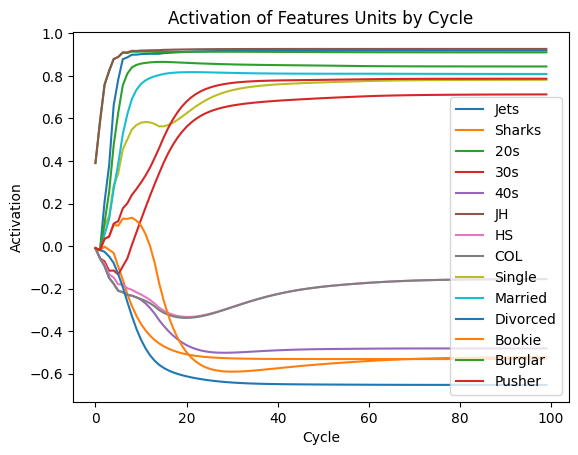

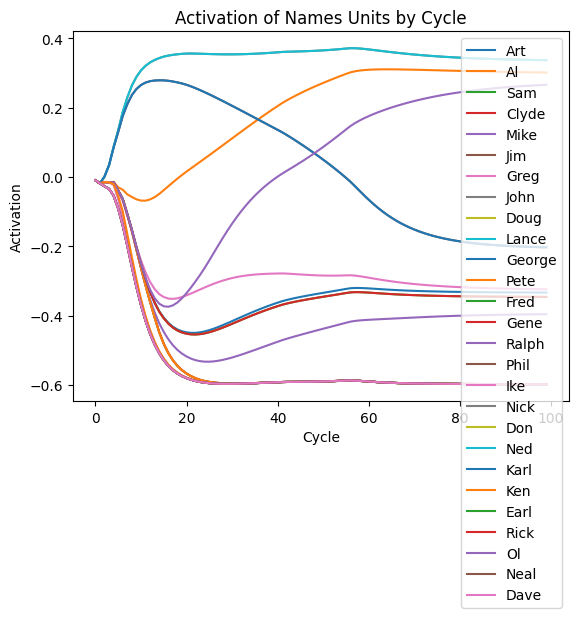

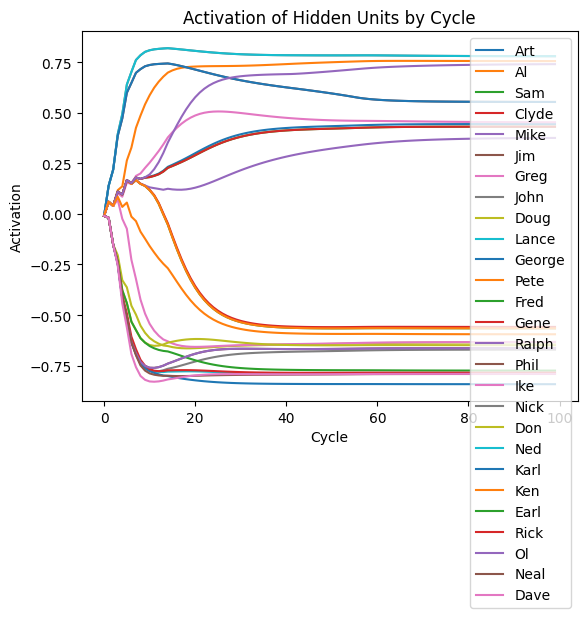


Features Pool Activations:
JH: 0.93
Jets: 0.92
20s: 0.91
Burglar: 0.84
Married: 0.81
Pusher: 0.79
Single: 0.78
30s: 0.71
HS: -0.16
COL: -0.16
40s: -0.48
Bookie: -0.52
Sharks: -0.53
Divorced: -0.65

Names Pool Activations:
John: 0.34
Lance: 0.34
Al: 0.30
Ralph: 0.27
George: -0.20
Jim: -0.20
Greg: -0.32
Art: -0.33
Fred: -0.35
Gene: -0.35
Mike: -0.40
Clyde: -0.60
Sam: -0.60
Pete: -0.60
Ken: -0.60
Ike: -0.60
Ol: -0.60
Rick: -0.60
Earl: -0.60
Doug: -0.60
Phil: -0.60
Karl: -0.60
Ned: -0.60
Don: -0.60
Neal: -0.60
Nick: -0.60
Dave: -0.60

Hidden Pool Activations:
John: 0.78
Lance: 0.78
Al: 0.75
Ralph: 0.74
Jim: 0.55
George: 0.55
Greg: 0.45
Art: 0.44
Fred: 0.43
Gene: 0.43
Mike: 0.38
Clyde: -0.56
Sam: -0.57
Pete: -0.57
Ken: -0.59
Ike: -0.63
Doug: -0.64
Don: -0.65
Phil: -0.66
Ol: -0.66
Nick: -0.67
Earl: -0.77
Rick: -0.78
Ned: -0.79
Dave: -0.79
Neal: -0.79
Karl: -0.84


In [4]:
# Usage: Who is in his 20s and has only completed junior high?
featurePool.setExtInput([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
namePool.setExtInput([0] * 27)

pools = [featurePool, namePool, hiddenPool]
pools = RunSimulation(pools, NCYCLES)

PlotPools(pools)

rankedActivations = RankActivationsByPool(pools)
for poolName, activations in rankedActivations.items():
    print(f"\n{poolName.capitalize()} Pool Activations:")
    for unitName, activation in activations:
        print(f"{unitName}: {activation:.2f}")

# Attempting Interactive Display

In [5]:
def free_local_port(port='8050'):
    try:
        port_process = subprocess.run(
            ["lsof", "-t", "-i", f":{port}"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        pids = port_process.stdout.strip().split()
        if pids:
            print(f"Port {port} is in use by PIDs: {pids}")
            for pid in pids:
                subprocess.run(["kill", "-9", pid], check=True)
                print(f"Killed process with PID: {pid}")
        else:
            print(f"Port {port} is free.")
    except Exception as e:
        print(f"An error occurred: {e}")

def getActivation(graph, rest_act=-0.1):
    activations = {node: rest_act for node in graph.nodes()}
    for u, v, d in graph.edges(data=True):
        activations[u] += d["weight"]
        if u != v:
            activations[v] += d["weight"]
    return activations, rest_act

def activationSizing(act, low_bound=20, high_bound=50):
    max_act = max(act.values())
    min_act = min(act.values())
    if max_act == min_act:
        return [(low_bound + high_bound) // 2] * len(act)
    return [
        low_bound + (x - min_act) * (high_bound - low_bound) / (max_act - min_act)
        for x in act.values()
    ]

pools = [featurePool, namePool, hiddenPool] # Using code from the first section, just combine.

def toGraph(pools):
    G = nx.DiGraph()  
    for pool in pools:
        for sender_idx, weight_matrix in pool.weights.items():
            sender_pool = pools[sender_idx]
            for i, sender_unit in enumerate(sender_pool.unitNames):
                for j, receiver_unit in enumerate(pool.unitNames):
                    weight = weight_matrix[i, j]
                    if weight != 0:  # Add edge only for non-zero weights
                        G.add_edge(sender_unit, receiver_unit, weight=weight)
    return G

def figurizeGraph(G, activations): # Graph. to plotly figure!
    pos = nx.spring_layout(G, seed=42)
    x_nodes = [pos[node][0] for node in G.nodes()]
    y_nodes = [pos[node][1] for node in G.nodes()]

    edges = list(G.edges(data=True))
    edge_x, edge_y = [], []
    for edge in edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=2, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    sizes = activationSizing(activations)
    node_trace = go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers+text',
        text=list(G.nodes()),
        marker=dict(
            size=sizes,
            color=list(activations.values()),
            colorscale='Viridis',
            colorbar=dict(title="Activation"),
            showscale=True
        ),
        textposition="top center"
    )

    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        title="IAC Model Graph Visualization"
    )
    return fig

def run_dash_app(pools, port=8050):
    app = Dash(__name__)

    G = toGraph(pools)
    activations, _ = getActivation(G)

    app.layout = html.Div([
        dcc.Graph(id='graph', figure=figurizeGraph(G, activations)),
    ])

    free_local_port(port)  # Free the port if in use
    app.run_server(debug=True, port=int(port))

In [6]:
run_dash_app(pools)

Port 8050 is free.


Produces this - messy, but it is interactive!

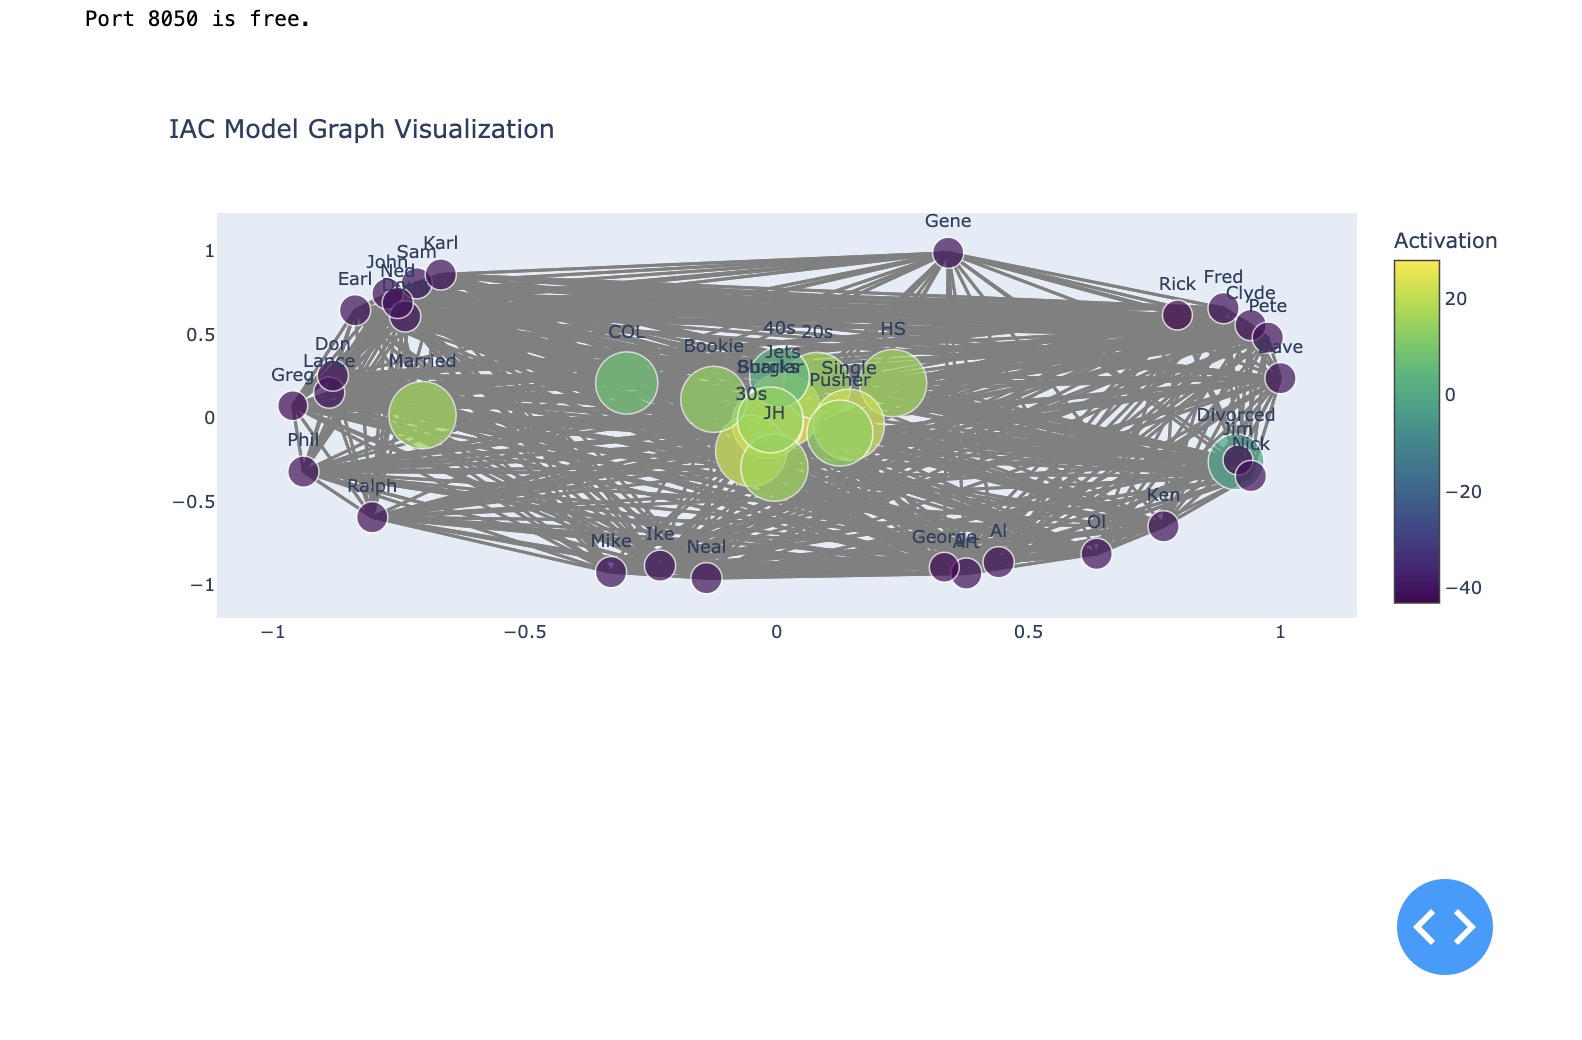